In [3]:
import os, sys
import numpy as np
from collections import OrderedDict as OD
#import uproot3 as uproot
#import uproot as uproot
import uproot 
import hist
import matplotlib.pyplot as plt
import mplhep as hep

sys.path.insert(1, '../') # to import file from other directory (../ in this case)

from htoaa_Settings import *

era = Era_2018
print(f"{era = }")

sFIn_dict = {
        Era_2016: "",
        Era_2017: "",        
        Era_2018: {
            "Data": {
                "fileName": "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions18/13TeV/PileUp/UltraLegacy/PileupHistogram-goldenJSON-13tev-2018-69200ub-99bins.root",
                "histogramName": "pileup"
            },

            "MC"  : {
                "fileName": "/eos/cms/store/user/ssawant/htoaa/analysis/20230720_DataVsMC_woBtagWgt_wDeepTagbbVsL/2018/analyze_htoaa_stage1.root",
                "histogramName": "evt/$SAMPLECATEGORY/hPileup_nTrueInt_central",
                "sampleCategories": ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
            }
        }
    }

sFOut_dict = {
        Era_2016: "",
        Era_2017: "",        
        Era_2018: {        
            "fileName": "../data/correction/mc/PURewgt/PURewgts_2018.root",
            "histogramName": "MC_PURewgt"
        },
    }

era = '2018'


Data file: /afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions18/13TeV/PileUp/UltraLegacy/PileupHistogram-goldenJSON-13tev-2018-69200ub-99bins.root
Data histogram: pileup


 hData (<class 'uproot.models.TH.Model_TH1D_v3'>): hData = <TH1D (version 3) at 0x7fc9219a8eb0>, hData.axes[0].edges() = array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.]), hData.axis().edges() = array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 

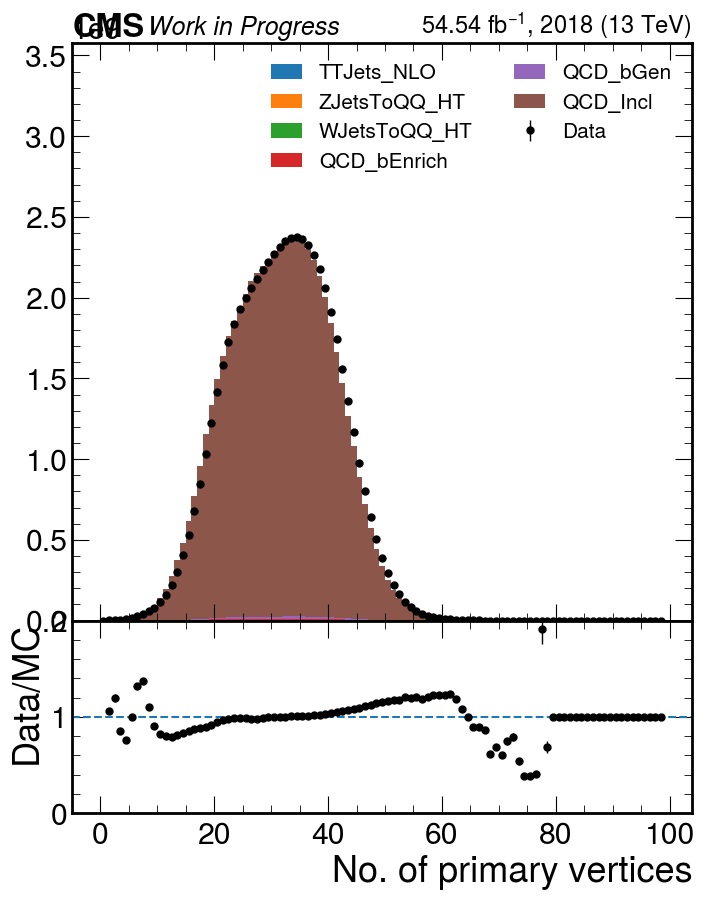

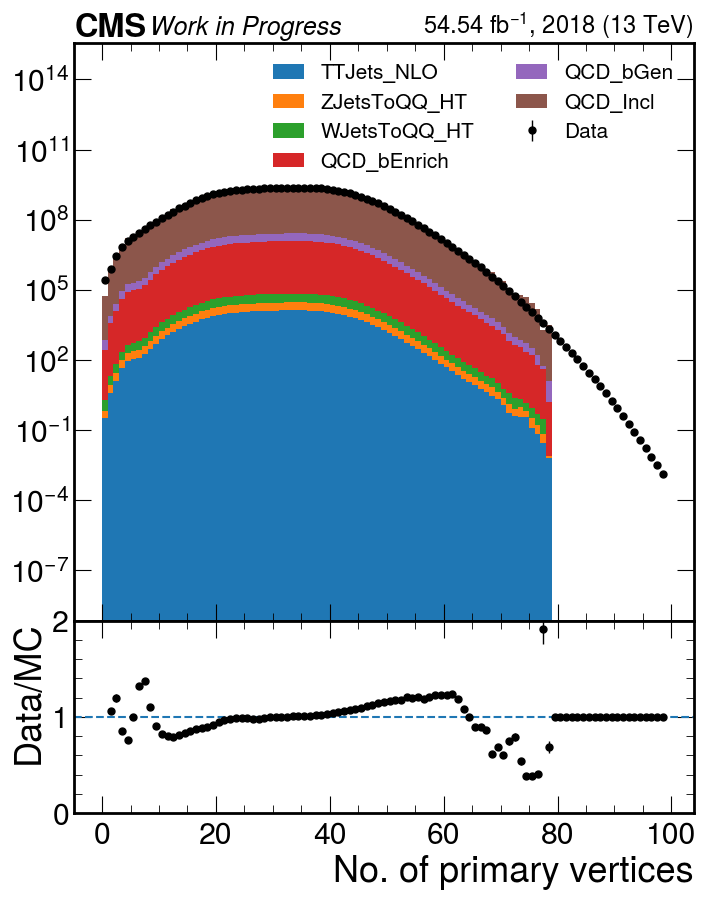

In [4]:
sData = "Data"
MCBkg_list = sFIn_dict[era]["MC"]["sampleCategories"]

luminosity = 54.54  #59.83
cmsWorkStatus='Work in Progress'
xAxisLabel = 'No. of primary vertices'

plt.style.use([hep.style.CMS])
fOut = uproot.recreate(sFOut_dict[era]["fileName"])

for yAxisScale in ['linearY', 'logY']: # ['linearY']
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

    # data -------------------------------------------------------------------------------------------
    print(f'Data file: {sFIn_dict[era]["Data"]["fileName"]}')
    fData = uproot.open( sFIn_dict[era]["Data"]["fileName"] )

    print(f'Data histogram: {sFIn_dict[era]["Data"]["histogramName"]}')
    hData = fData[sFIn_dict[era]["Data"]["histogramName"]]

    print(f"\n\n hData ({type(hData)}): {hData = }, {hData.axes[0].edges() = }, {hData.axis().edges() = }, {hData.values() = }, {hData.variances() = }")

    #hep.histplot(hData.values, bins=hData.edges, ax=ax[0], yerr=np.sqrt(hData.variances), histtype='errorbar', color='black', label='Data')
    hep.histplot(hData.values(), bins=hData.axes[0].edges(), ax=ax[0], yerr=np.sqrt(hData.variances()), histtype='errorbar', color='black', label='Data')

    # MC ---------------------------------------------------------------------------------------------
    print(f'MC file: {sFIn_dict[era]["MC"]["fileName"]}')
    fMC = uproot.open( sFIn_dict[era]["MC"]["fileName"] )

    hBkgTot_values = None
    hBkgTot_variance = None
    if len(MCBkg_list) > 0:
        hBkg_list = []
        sBkg_list = []
        hBkg_integral_list = []
        for sample_category in MCBkg_list:
            histogramName_toUse = sFIn_dict[era]["MC"]["histogramName"]
            histogramName_toUse = histogramName_toUse.replace('$SAMPLECATEGORY', sample_category)
            h = fMC[histogramName_toUse]

            hBkg_list.append(h)
            sBkg_list.append(sample_category)
            #hBkg_integral_list.append(h.values.sum())
            hBkg_integral_list.append(h.values().sum())

        # Scale MC to match no. of events in data ----
        #scaleMC = hData.values.sum() / np.sum(hBkg_integral_list)
        scaleMC = hData.values().sum() / np.sum(hBkg_integral_list)
        print(f"Integral:: Data {hData.values().sum()},  MC {np.sum(hBkg_integral_list)},  {scaleMC = }")

        # sort histograms in decreasing yield
        isReverseSortForStack = True
        idx_hBkg_sortedByIntegral = sorted(range(len(hBkg_integral_list)), key=lambda i: hBkg_integral_list[i], reverse=isReverseSortForStack)            

        print(f"sBkg_list: {sBkg_list} \nhBkg_integral_list (total {sum(hBkg_integral_list)}): {hBkg_integral_list} ")
        print(f"sBkg_list sorted by integral: {[(sBkg_list[idx], hBkg_integral_list[idx]) for idx in idx_hBkg_sortedByIntegral]}")            

        hStack_list = [ hBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
        sStack_list = [ sBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
        print(f"sStack_list: {sStack_list}")

        hStack_values_list    = np.array( [ h.values()    * scaleMC         for h in hStack_list ] )
        hStack_variance_list  = np.array( [ h.variances() * (scaleMC**2)    for h in hStack_list ] )
        hStack_error_list     = np.array( [ np.sqrt(h.variances())          for h in hStack_list ] )
        hStack_edges          = hData.axes[0].edges() if sData else hStack_list[0].edges

        hBkgTot_values        = np.sum(hStack_values_list, axis=0)
        hBkgTot_variance      = np.sum(hStack_variance_list, axis=0)
        print(f"hBkgTot_values sum: {sum(hBkgTot_values)}")

        # plot stack
        hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], yerr=hStack_error_list, histtype='fill', stack=True, label=sStack_list, sort='yield')

        # plot total background
        #hep.histplot(hBkgTot_values, bins=hStack_edges, ax=ax, yerr=np.sqrt(hBkgTot_variance), histtype='errorbar', color='grey', label='Total background')



        #print(f"hData.shape[0]: {len(hData.values)}")
        # ratio plot
        ratio_values = np.divide(hData.values(), hBkgTot_values, where=hBkgTot_values!=0, out=np.ones(len(hData.values())))
        ratio_error  = np.sqrt(hData.variances())            
        ratio_error  = np.divide(ratio_error, hBkgTot_values, where=hBkgTot_values!=0, out=np.zeros(len(hData.values())))
        '''
        print(f"hData.values: {hData.values}")
        print(f"hBkgTot_values: {hBkgTot_values}")
        print(f"ratio_values: {ratio_values}")
        print(f"ratio_error: {ratio_error}")
        '''
        print(f"\n\n hData ({type(hData)}): {hData}")
        hTmp = hData
        #print(f": {}")


        
        hep.histplot(ratio_values, bins=hData.axes[0].edges(), ax=ax[1], yerr=ratio_error, histtype='errorbar', color='black', label='Data')
        #if xAxisRange: ax[1].set_xlim(xAxisRange[0], xAxisRange[1])
        ax[1].set_ylim(0, 2)
        if xAxisLabel: ax[1].set_xlabel(xAxisLabel)
        ax[1].set_ylabel('Data/MC')
        
        ax[1].axhline(y=1, linestyle='--')
                
            
            
            

        ax[0].legend(fontsize=15, loc='upper right', ncol=2)
        if yAxisScale == 'logY': ax[0].set_yscale('log', base=10)
        ax[0].set_ymargin(0.5)

        #hPURewgt = hData.to_hist()
        nBins    = len(hData.axes[0].centers())
        xLow     = hData.axes[0].edges()[0]
        xHigh    = hData.axes[0].edges()[-1]
        hPURewgt = hist.Hist.new.Regular(nBins,xLow,xHigh, name="PURewgt", label="PUReweights vs PU").Weight()


        x1 = list(zip(ratio_values, ratio_error))
        #x1 = [ratio_values, ratio_error]
        print(f"x1 ({type(x1)}): {x1} ")
        #for x_ in x1:
        #    print(f"{x_}")
        print(f"{len(ratio_values) = }, {len(ratio_error) = }, {len(hPURewgt.axes[0].edges) = }")
        print(f"ratio_values {len(ratio_values)}: {ratio_values}")
        print(f"ratio_error {len(ratio_error)}: {ratio_error}")
        print(f"hPURewgt.values() {len(hPURewgt.values())}: {hPURewgt.values()}")
        print(f"hPURewgt.variance() {len(hPURewgt.variances())}: {hPURewgt.variances()}")
        print(f"hPURewgt.axes[0].centers {len(hPURewgt.axes[0].centers)}: {hPURewgt.axes[0].centers}")
        print(f"hPURewgt.axes[0].edges {len(hPURewgt.axes[0].edges)}: {hPURewgt.axes[0].edges}")
        print(f"hPURewgt: {hPURewgt}")

        hPURewgt[0:len(hPURewgt.values())] = list(zip(ratio_values, ratio_error)) 

        print(f"\n\n after change>>\nhPURewgt.values() {len(hPURewgt.values())}: {hPURewgt.values()}")
        print(f"hPURewgt.variance() {len(hPURewgt.variances())}: {hPURewgt.variances()}")
        print(f"hPURewgt.axes[0].centers {len(hPURewgt.axes[0].centers)}: {hPURewgt.axes[0].centers}")
        print(f"hPURewgt.axes[0].edges {len(hPURewgt.axes[0].edges)}: {hPURewgt.axes[0].edges}")
        print(f"hPURewgt: {hPURewgt}")
        print(f"hPURewgt.axes {len(hPURewgt.axes)}: {hPURewgt.axes}")





        #hPURewgt[]
        if yAxisScale == 'linearY':
            print(f"hPURewgt ({type(hPURewgt)}): \n{hPURewgt} ")
            fOut[sFOut_dict[era]["histogramName"]] = hPURewgt

        hep.cms.label(ax=ax[0], data=True if sData else False, year=era, lumi=luminosity, label=cmsWorkStatus, fontsize=18)

        
        #fig.savefig('%s/%s_%s_%s.png' % (sOpDir,histo_name,systematic, yAxisScale), transparent=False, dpi=80, bbox_inches="tight")

        #plt.close(fig)


fOut.close()
